In [1]:
!pip install -Uqq fastbook
!pip install fastai --upgrade --use-feature=2020-resolver
import fastbook
fastbook.setup_book()

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

torchvision 0.11.1 requires torch==1.10.0, but you'll have torch 1.7.0 which is incompatible.
     |▊                               | 18.6 MB 17.6 MB/s eta 0:00:49     |████████████████████████████████| 881.9 MB 5.3 kB/s  eta 0:00:01    |█▌                              | 42.5 MB 20.1 MB/s eta 0:00:42     |████▎                           | 116.6 MB 24.2 MB/s eta 0:00:32     |████▊                           | 130.0 MB 21.2 MB/s eta 0:00:36     |████▊                           | 131.3 MB 21.2 MB/s eta 0:00:36     |███████                         | 191.2 MB 25.4 MB/s eta 0:00:28     |███████▉                        | 214.9 MB 25.3 MB/s eta 0:00:27     |██████████████                  | 382.9 MB 23.0 

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '609fc914bb8f4662899c23b7ccde4088')
search_images_bing
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [4]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [5]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

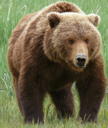

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

In [7]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [8]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
fns = get_image_files(path)
fns

(#428) [Path('bears/grizzly/00000047.jpg'),Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000107.jpg'),Path('bears/grizzly/00000036.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/grizzly/00000110.jpg'),Path('bears/grizzly/00000029.jpg'),Path('bears/grizzly/00000112.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#0) []

In [11]:
failed.map(Path.unlink);

In [13]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = bears.dataloaders(path)

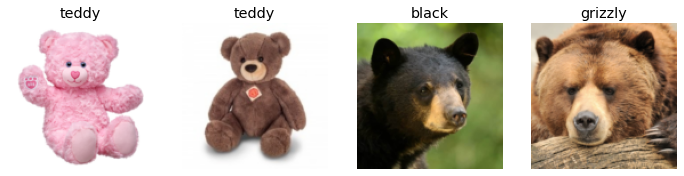

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
#hide

In [16]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [17]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.318665,0.052023,0.011765,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.166564,0.016928,0.000000,00:15
1,0.116328,0.007858,0.000000,00:16
2,0.090286,0.005906,0.000000,00:14
3,0.082189,0.005326,0.000000,00:14


In [18]:
learn.export()

In [19]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [20]:
learn_inf = load_learner(path/'export.pkl')

In [21]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([5.8286e-06, 9.9999e-01, 2.3759e-06]))

In [22]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [24]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [26]:
img = PILImage.create(btn_upload.data[-1])

In [27]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [34]:
pred,pred_idx,probs = learn_inf.predict(img)

In [35]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9949')

In [36]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [37]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [38]:
btn_upload = widgets.FileUpload()

In [39]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [40]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6 MB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 556 kB 28.5 MB/s eta 0:00:01
     |████████████████████████████████| 394 kB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 3.7 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 11.7 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.3.0 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.16 O